In [1]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/shenwanxiang/Research/aliyun_sync/COMPASS/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass #, get_minmal_epoch
from compass.utils import plot_embed_with_label, score2
from compass.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)
import warnings
warnings.filterwarnings("ignore")
from glob import glob

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

/home/shenwanxiang/anaconda3/envs/compass/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lmp = {'PFT': 'Compass' + '-PFT',
 'LFT': 'Compass' + '-LFT',
 'FFT': 'Compass' + '-FFT',
 'NetBio': 'NetBio',
 'Teff': 'Teff',
 'CD8': 'CD8',
 'CTL': 'CTL',
 'CIS': 'CIS',
 'IS': 'IS',
 'ICA': 'ICA',
 'PDL1': 'PDL1',
 'PGM': 'PGM',
 'CKS': 'CKS',
 'PD1': 'PD1',
 'TIDE': 'TIDE',
 'GeneBio': 'GeneBio',
 'TAM': 'TAM',
 'NFT': 'Compass' + '-NFT',
 'CTLA4': 'CTLA4',
 'IMPRES': 'IMPRES',
 'GEP': 'GEP',
 'CAF': 'CAF',
 'Texh': 'Texh',
 'IFNG': 'IFNG',
 'MIAS': 'MIAS',
 'NRS': 'NRS'}
def label_map(x):
    return pd.Series(x).map(lmp).tolist()

In [3]:
data_path = '../../../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
SU2CLC2             SU2CLC2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
MGH                     MGH\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
SU2CLC1            SU2CLC1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [4]:
cohorts = pd.Series(cohorts).map(size).to_list()

## loading bechmarks

In [5]:
from glob import glob
csvs = glob('./baseline_run/LOCO_42/LOCO_*/source_performance.tsv')

res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    res.append(df)

data1 = pd.concat(res)
data1['cohort'] = data1.test_cohort.map(size)
data1.head()

,NR,R,0,1,train_cohort,test_cohort,best_C,mode,cohort
Index,,,,,,,,,
Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.500241,0.499759,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.498756,0.501244,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.500422,0.499578,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.500434,0.499566,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)
Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.500624,0.499376,Leave_Choueiri_out,Choueiri,0.1,NRS,Choueiri\n(n=16)


## loading conceptor

In [6]:
csvs = glob('./conceptor_run/LOCO_a100/LOCO_*/source_performance.tsv')
res = []
for csv in csvs:
    df = pd.read_csv(csv, index_col =0, sep='\t')
    res.append(df)

data2 = pd.concat(res)
data2['cohort'] = data2.test_cohort.map(size)
data2.head()

,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer,cohort
Index,,,,,,,,,,,,,
Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.997618,0.002382,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.571495,0.428505,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.970280,0.029720,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.981604,0.018396,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)
Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.709602,0.290398,Leave_Choueiri_out,Choueiri,47,875,LFT,42,32.0,[16],Choueiri\n(n=16)


## Merge & analysis

In [7]:
data = data2._append(data1)
data = data.reset_index()
data.head()

,Index,NR,R,0,1,train_cohort,test_cohort,best_epoch,n_trainable_params,mode,seed,batch_size,task_dense_layer,cohort,best_C
0,Choueiri_CCR_2016-p014-ar-325,0.0,1.0,0.997618,0.002382,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
1,Choueiri_CCR_2016-p018-ar-318,1.0,0.0,0.571495,0.428505,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
2,Choueiri_CCR_2016-p021-ar-301,1.0,0.0,0.970280,0.029720,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
3,Choueiri_CCR_2016-p027-ar-866,1.0,0.0,0.981604,0.018396,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN
4,Choueiri_CCR_2016-p041-ar-306,1.0,0.0,0.709602,0.290398,Leave_Choueiri_out,Choueiri,47.0,875.0,LFT,42.0,32.0,[16],Choueiri\n(n=16),NaN


In [8]:
data['size'] = data.cohort.apply(lambda x:x.split('n=')[-1].replace(')', ''))
data['size'] = data['size'].astype(int)
def cohort_size(x):
    if x <= 30:
       s = 'small'
    elif 100 > x > 30:
        s = 'medium'
    elif x > 100:
        s = 'large'
    return s
data['size_map'] = data['size'].map(cohort_size)

In [9]:
data.seed = data.seed.fillna(42.)
seeds = [24, 42, 64]  
data = data[data.seed.isin(seeds)]

In [10]:
data.to_csv('LOCO_raw_data.csv')

In [11]:
dfp = data.groupby(['size_map', 'mode', 'seed']).apply(lambda x: score2(x['R'], x['1'],
                                                             x[['0', '1']].idxmax(axis=1).astype(int)))
dfp = dfp.apply(pd.Series)
dfp.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfp = dfp.reset_index()


In [12]:
data.groupby(['size_map', 'mode', 'seed']).size().unique()

array([ 672, 1344,  331,  662,  130,  260])

In [13]:
dfp[dfp['mode'] == 'PFT']

,size_map,mode,seed,ROC,PRC,F1,ACC,MCC
23,large,PFT,24.0,0.712541,0.553847,0.480447,0.723214,0.296047
24,large,PFT,42.0,0.719497,0.584478,0.521978,0.741071,0.347331
25,large,PFT,64.0,0.720647,0.580064,0.539906,0.708333,0.331151
54,medium,PFT,24.0,0.797692,0.595854,0.641350,0.743202,0.456013
55,medium,PFT,42.0,0.775464,0.571604,0.611872,0.743202,0.422668
56,medium,PFT,64.0,0.778147,0.631245,0.616822,0.752266,0.434828
85,small,PFT,24.0,0.545478,0.412449,0.238806,0.607692,0.044427
86,small,PFT,42.0,0.518293,0.401099,0.309859,0.623077,0.104745
87,small,PFT,64.0,0.530996,0.418004,0.318841,0.638462,0.140592


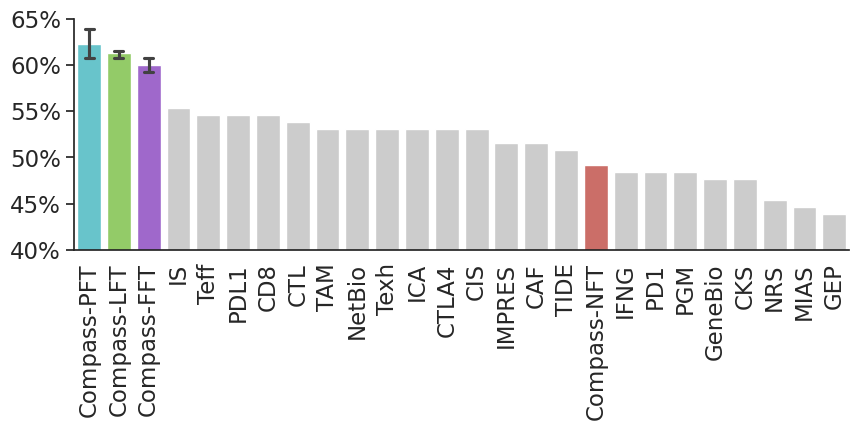

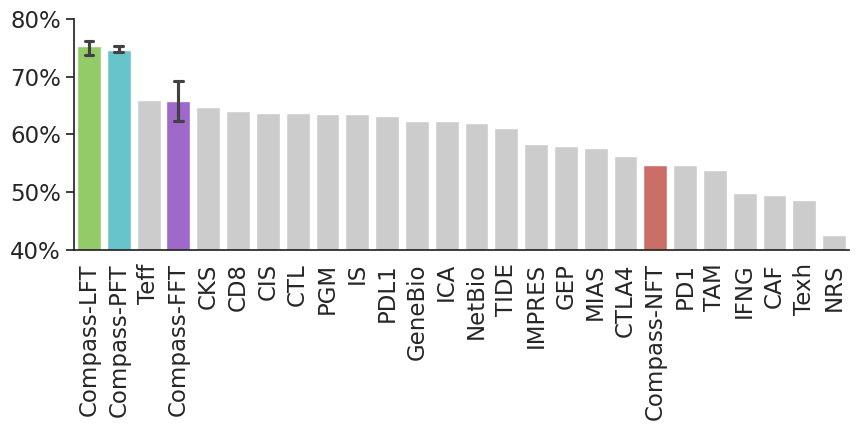

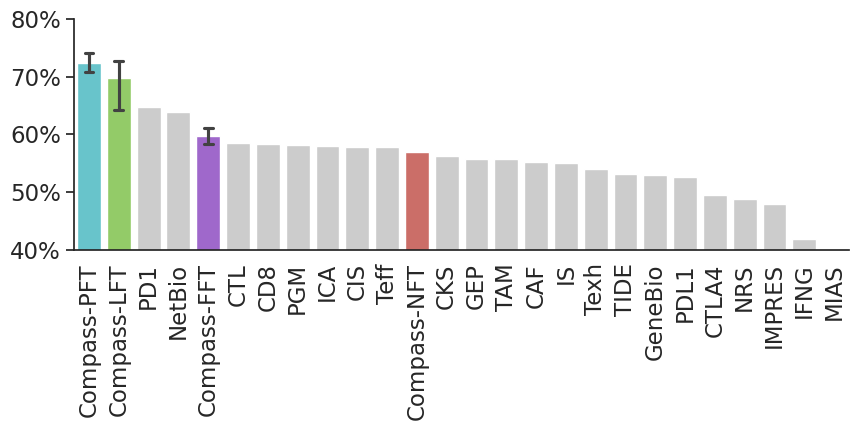

In [14]:
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

#f4 = sns.palettes.color_palette('Blues', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

values = 'ACC'
for s, ylim in zip(['small', 'medium', 'large'], [(0.4, 0.65), (0.4, 0.80), (0.4, 0.80)]):

    dfp1 = dfp[dfp['size_map'] == s]

    fig,ax = plt.subplots(figsize=(10, 3), nrows=1, )
    order = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    sns.barplot(data = dfp1, x='mode', y = values, order = order,width = 0.8, capsize = 0.3, 
                 ax=ax, palette=mode_palette) #errorbar = ('ci',80),
    # sns.swarmplot(data = dfp1, x='mode', y = values, order = order, 
    #              ax=ax, palette=mode_palette, edgecolor='k', linewidth = 0.5, size=4) #errorbar = ('ci',80),
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel(None) #'Accuracy(%)'
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
    ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
    label_map(order), 
    rotation=90)  # <====== HERE is the ke

    ax.set_xlabel('')
    #fig.savefig('./group_bar_%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )

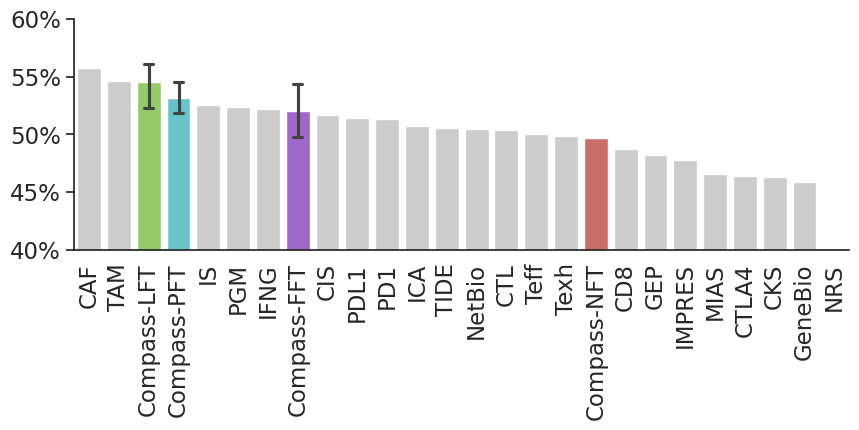

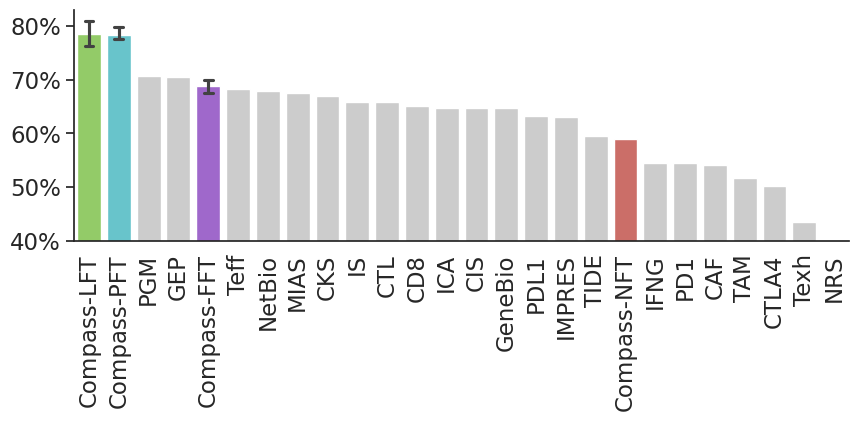

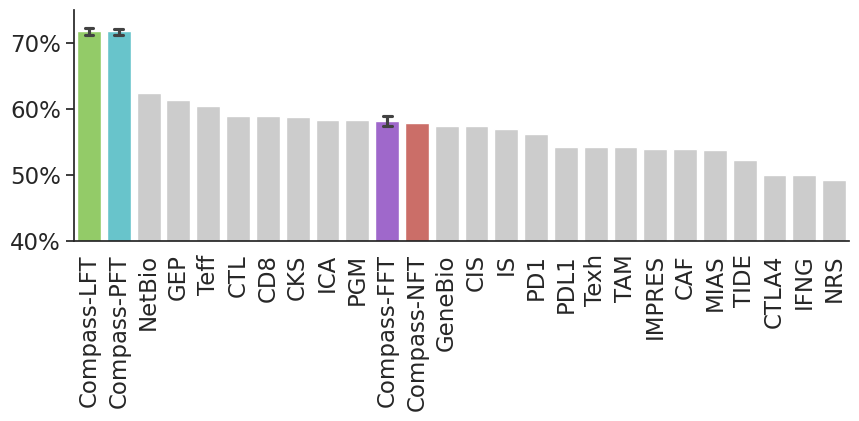

In [15]:
ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

#f4 = sns.palettes.color_palette('Blues', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                # 'CKS':f4[4], 'GEP':f4[5],  'MIAS':f4[6],'PDL1':f4[7],
                # 'Teff':f4[8], 'GeneBio':f4[9],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

values = 'ROC'
for s, ylim in zip(['small', 'medium', 'large'], [(0.4, 0.60), (0.4, 0.83), (0.4, 0.75)]):

    dfp1 = dfp[dfp['size_map'] == s]

    fig,ax = plt.subplots(figsize=(10, 3), nrows=1, )
    order = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    sns.barplot(data = dfp1, x='mode', y = values, order = order,width = 0.8, capsize = 0.3, 
                 ax=ax, palette=mode_palette) #errorbar = ('ci',80),
    # sns.swarmplot(data = dfp1, x='mode', y = values, order = order, 
    #              ax=ax, palette=mode_palette, edgecolor='k', linewidth = 0.5, size=4) #errorbar = ('ci',80),
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel(None) #'Accuracy(%)'
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
    ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
    label_map(order), 
    rotation=90)  # <====== HERE is the ke

    ax.set_xlabel('')
    fig.savefig('./group_bar_%s_%s.svg' % (values, s), bbox_inches = 'tight', dpi= 96 )

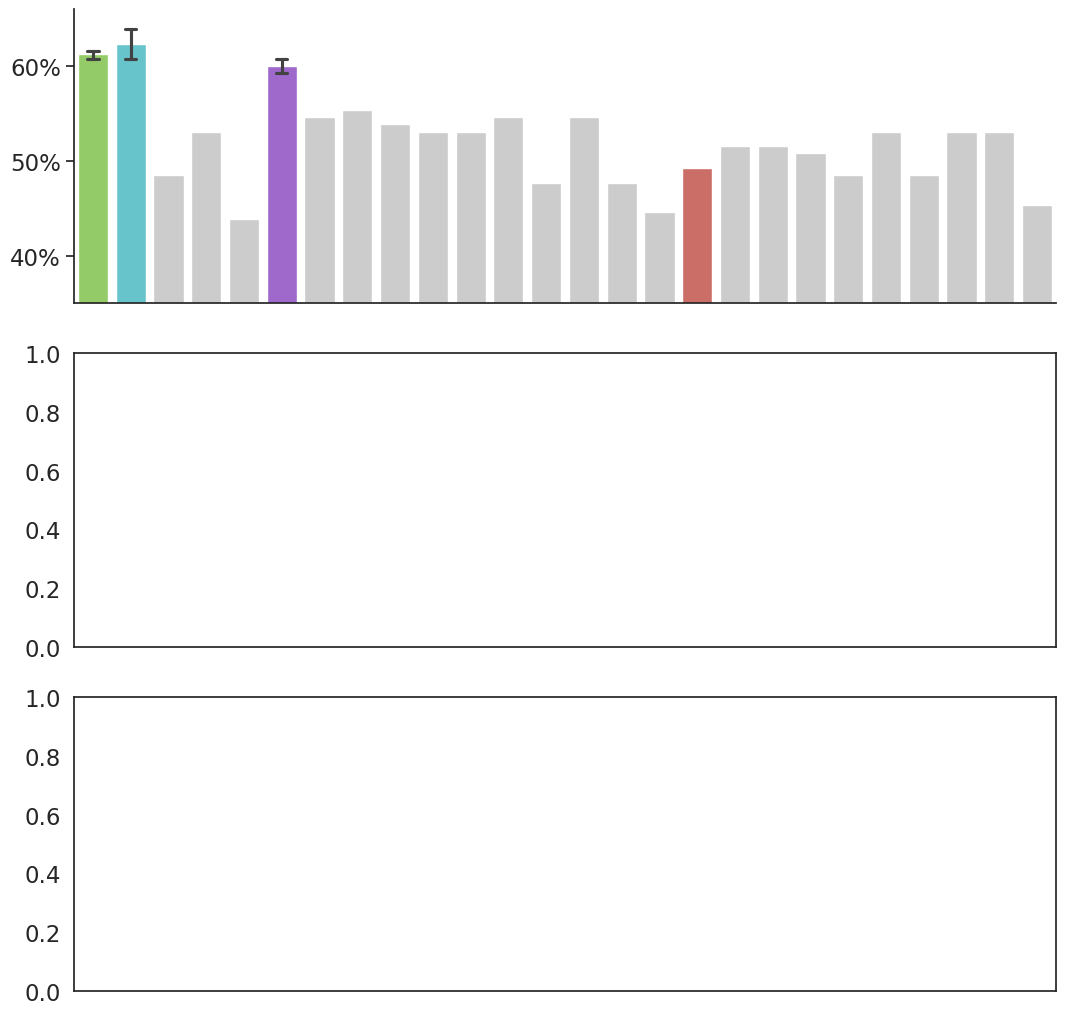

In [16]:
seeds = [42,24,64]
dfps = dfp[dfp.seed.isin(seeds)]

order = dfps.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()

fig,axes = plt.subplots(figsize=(11, 3*3.5), nrows=3,sharex=True )


ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

values = 'ACC'
for s, ylim, ax in zip(['small', 'medium', 'large'], [(0.35, 0.66), (0.35, 0.78), (0.35, 0.75)], axes):

    if s != 'small':
        continue
        
    dfp1 = dfps[dfps['size_map'] == s]

    sns.barplot(data = dfp1, x='mode', y = values, order = order,width = 0.8, capsize = 0.3, 
                 ax=ax, palette=mode_palette) #errorbar = ('ci',80),
    # sns.swarmplot(data = dfp1, x='mode', y = values, order = order, 
    #              ax=ax, palette=mode_palette, edgecolor='k', linewidth = 0.5, size=6) #errorbar = ('ci',80),
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_ylabel(None) #Accuracy(%)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
    ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)

    if s == 'large':
        ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
    ax.set_xlabel('')

    ax.set_xticklabels(
    [], 
    rotation=90)  # <====== HERE is the ke

    ax.tick_params(axis='x', which='major', pad=1)
    
    plt.tight_layout() #h_pad = 4
    
fig.savefig('./group_bar_%s.pdf' % (values), bbox_inches = 'tight', dpi= 96 )
fig.savefig('./group_bar_%s.svg' % (values), bbox_inches = 'tight', dpi= 96 )

In [17]:
vals[:]

array([0.3, 0.4, 0.5, 0.6, 0.7])

In [18]:
x1 = dfps.groupby(['mode', 'size_map']).ACC.mean().sort_values(ascending=False).round(3).unstack().T[order]
std = dfps.groupby(['mode', 'size_map']).ACC.std().sort_values(ascending=False).round(3).unstack().T[order]
ACC_result = x1.astype(str)  # 先转换 mean 为字符串
for col in x1.columns:
    ACC_result[col] = x1[col].astype(str)  # 先转换 mean 为字符串
    ACC_result[col] = ACC_result[col] + std[col].apply(lambda x: f" ± {x}" if pd.notna(x) and x > 0 else "")

In [19]:
x1 = dfps.groupby(['mode', 'size_map']).MCC.mean().sort_values(ascending=False).round(3).unstack().T[order]
std = dfps.groupby(['mode', 'size_map']).MCC.std().sort_values(ascending=False).round(3).unstack().T[order]
MCC_result = x1.astype(str)  # 先转换 mean 为字符串
for col in x1.columns:
    MCC_result[col] = x1[col].astype(str)  # 先转换 mean 为字符串
    MCC_result[col] = MCC_result[col] + std[col].apply(lambda x: f" ± {x}" if pd.notna(x) and x > 0 else "")

In [20]:
x1 = dfps.groupby(['mode', 'size_map']).PRC.mean().sort_values(ascending=False).round(3).unstack().T[order]
std = dfps.groupby(['mode', 'size_map']).PRC.std().sort_values(ascending=False).round(3).unstack().T[order]
PRC_result = x1.astype(str)  # 先转换 mean 为字符串
for col in x1.columns:
    PRC_result[col] = x1[col].astype(str)  # 先转换 mean 为字符串
    PRC_result[col] = PRC_result[col] + std[col].apply(lambda x: f" ± {x}" if pd.notna(x) and x > 0 else "")

In [21]:
ACC_result['Metric'] = 'ACC'
MCC_result['Metric'] = 'MCC'
PRC_result['Metric'] = 'PRC'

In [22]:
ACC_result._append(MCC_result)._append(PRC_result).to_excel('loco_group.xlsx')

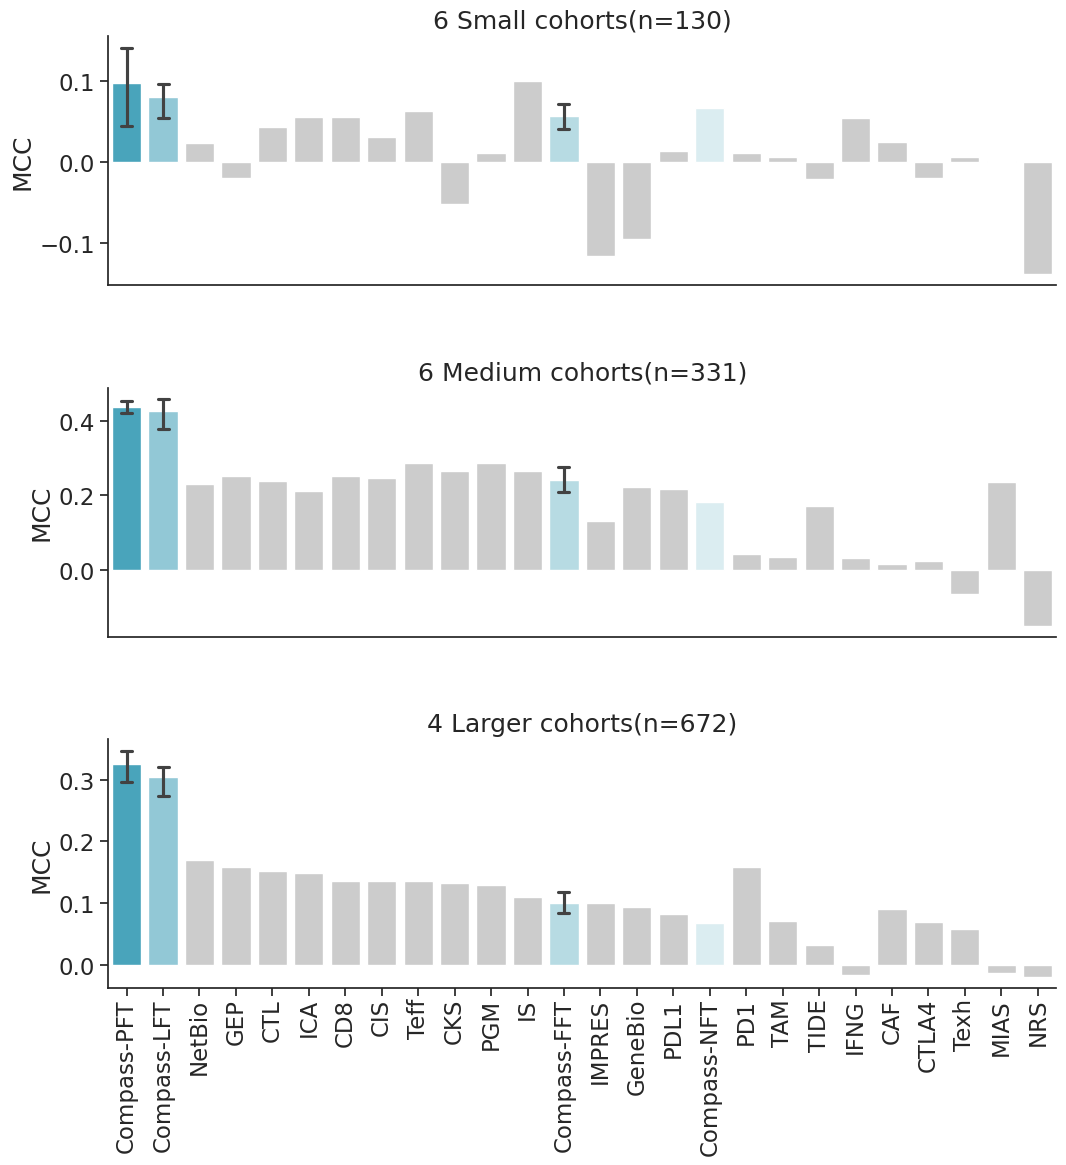

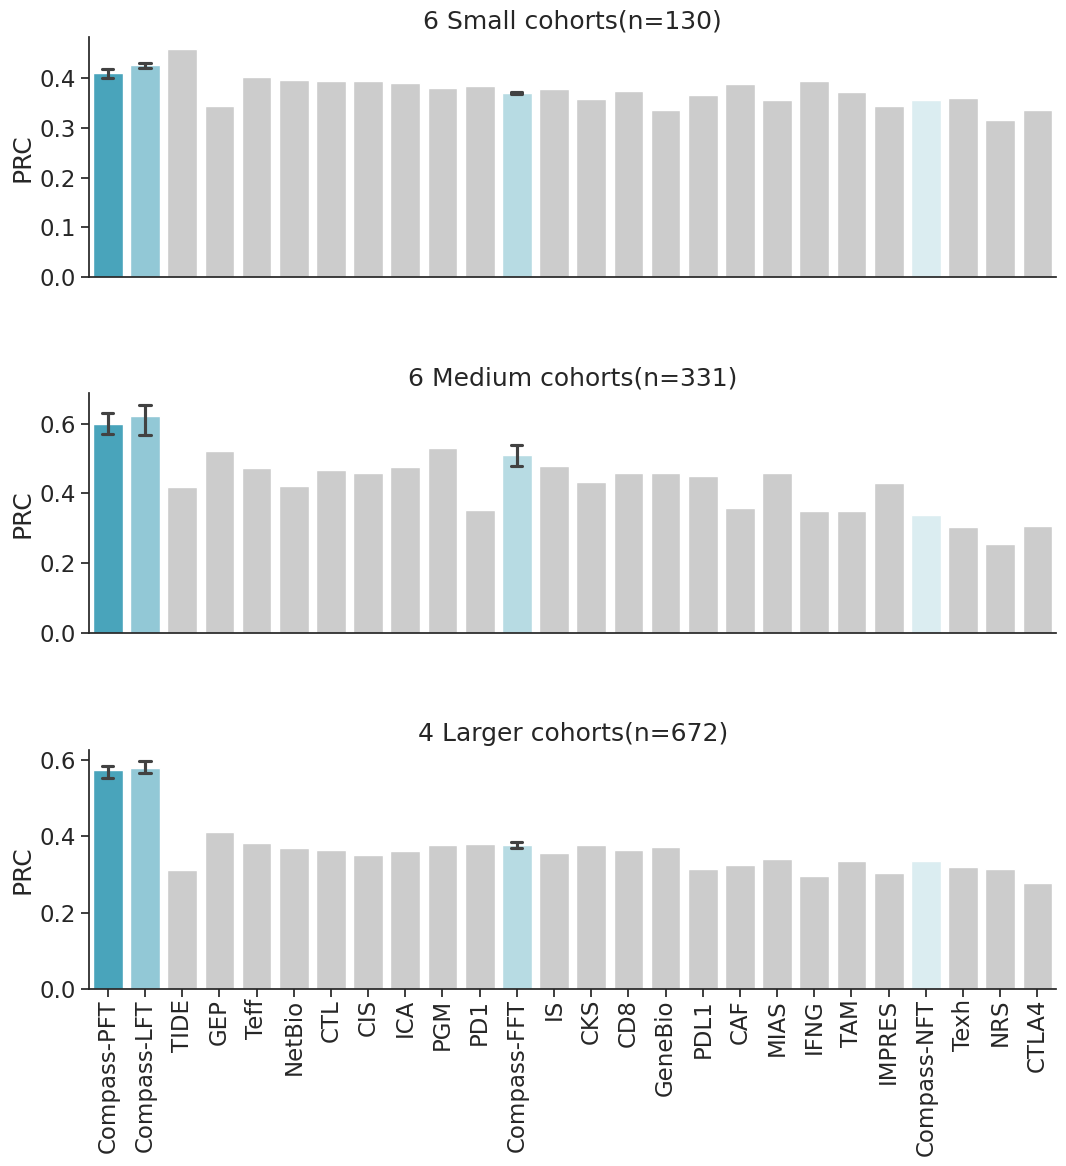

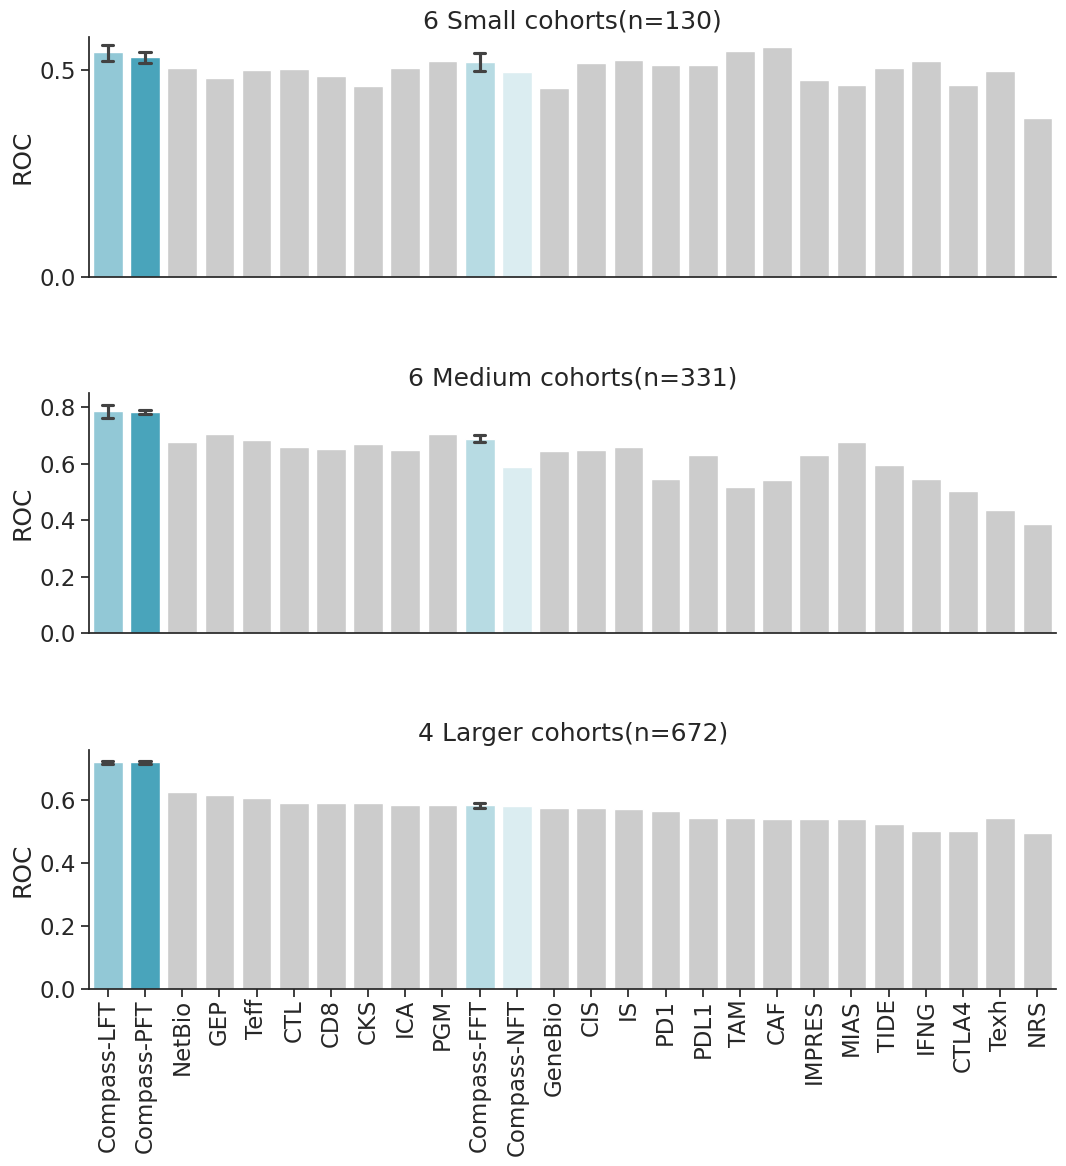

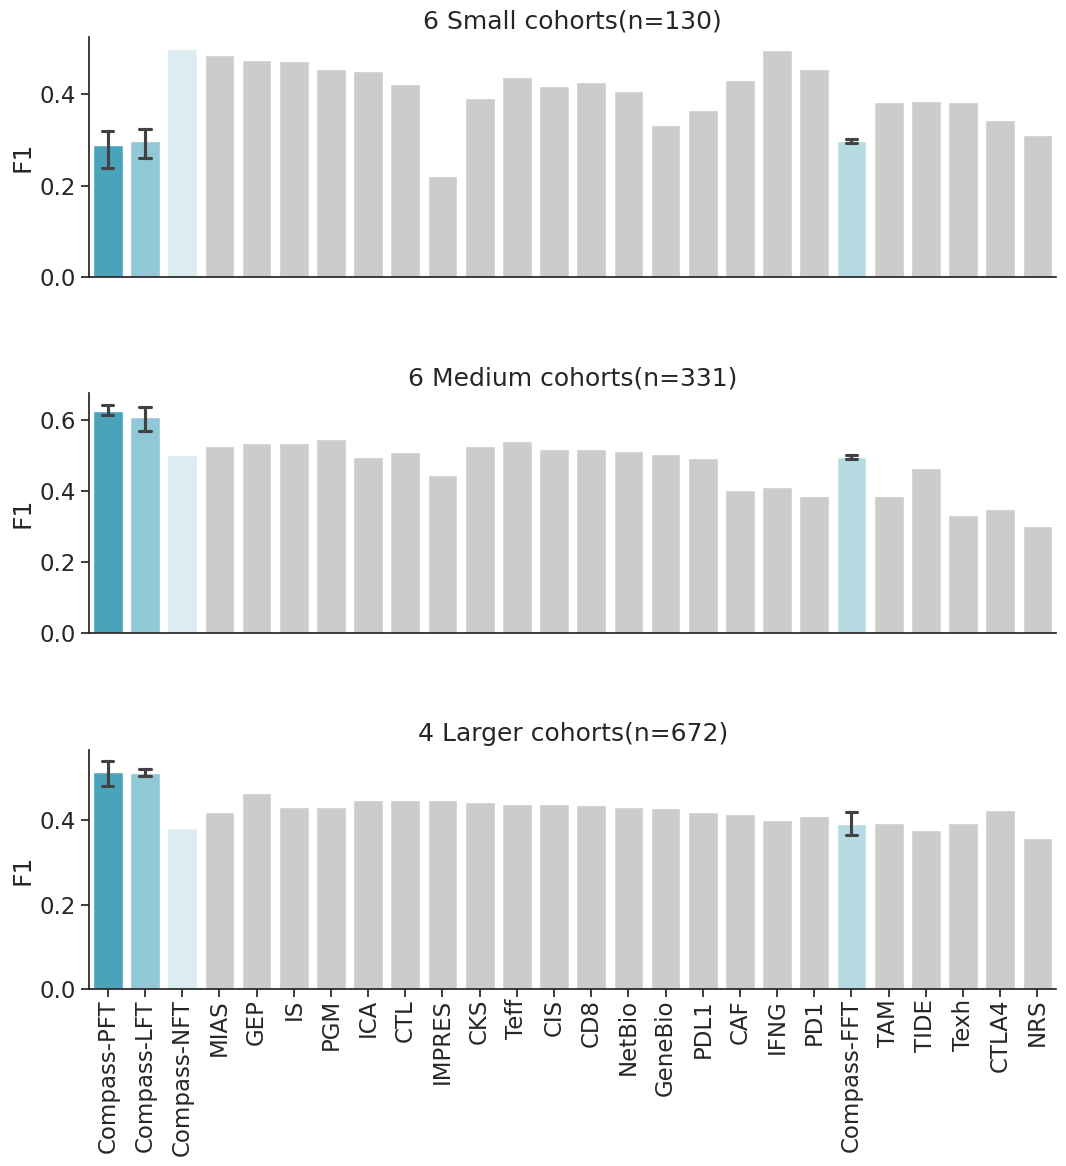

In [23]:
seeds = [24, 42,64] #24, 42, 64, 128
dfps = dfp[dfp.seed.isin(seeds)]
#order = dfps.groupby('mode')[values].median().sort_values(ascending=False).index.to_list()

compass_cmap = {'PFT':'#36AFCE', 'LFT':'#86CFE2','FFT':'#AFDFEB','NFT':'#D7EFF5', }


ot = '#cccccc'
f4 = sns.palettes.color_palette('hls', 4, desat = 1).as_hex()

mode_palette = { 'NFT':f4[0],'LFT':f4[1],  'PFT':f4[2], 'FFT':f4[3], 'PFT2':f4[2],
                'CKS':ot, 'GEP':ot,  'MIAS':ot,'PDL1':ot,
                'Teff':ot, 'GeneBio':ot,
                'TIDE':ot, 'TAM':ot, 'Texh':ot, 'CAF':ot, 'NRS':ot, 'CTLA4':ot, 'IMPRES':ot, 'PGM':ot,
                'PD1':ot,  'NetBio':ot, 
                'CD8':ot, 'IS':ot, 'IFNG':ot, 'ICA':ot, 'CTL':ot, 'CIS':ot, '42':ot,
                }

ylabels = ['6 Small cohorts(n=130)', '6 Medium cohorts(n=331)', '4 Larger cohorts(n=672)' ]

mode_palette.update(compass_cmap)

for values in ['MCC', 'PRC', 'ROC','F1'] :
    
    fig,axes = plt.subplots(figsize=(11, 4*3), nrows=3,sharex=True )

    order = dfps.groupby('mode')[values].median().sort_values(ascending=False).index.to_list()
 
    for s, ylabel, ax in zip(['small', 'medium', 'large'], ylabels, axes):
    
        dfp1 = dfps[dfps['size_map'] == s]
        
        sns.barplot(data = dfp1, x='mode', y = values, order = order,
                    width = 0.8, capsize = 0.3, 
                     ax=ax, palette=mode_palette) #errorbar = ('ci',80),
        # sns.swarmplot(data = dfp1, x='mode', y = values, order = order, 
        #              ax=ax, palette=mode_palette, edgecolor='k', linewidth = 0.5, size=6) #errorbar = ('ci',80),
        if values == 'ROC':
            if s == 'small':
                ax.set_ylim(0, 0.58)
                ax.set_yticks([0, 0.5])
                
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        #ax.set_ylim(ylim[0], ylim[1])
        ax.set_ylabel(values) #Accuracy(%)
        
        vals = ax.get_yticks()
        #ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals[:]])
        ax.tick_params(axis='y', which='major', right = False, top=False, direction = 'out',reset = True)
    
        if s == 'large':
            ax.tick_params(axis='x', which='major', right = False, top=False, direction = 'out',reset = True)
        ax.set_xlabel('')
    
        ax.set_xticklabels(
        label_map(order),  
        rotation=90)  # <====== HERE is the ke
    
        ax.tick_params(axis='x', which='major', pad=1)
        
        plt.tight_layout(h_pad = 3)

        ax.set_title(ylabel)
        
    #fig.savefig('./group_bar_%s_%s.pdf' % (values, s), bbox_inches = 'tight', dpi= 96 )
    fig.savefig('./group_bar_%s.svg' % (values), bbox_inches = 'tight', dpi= 96 )